In [1]:
import pandas as pd
import numpy as np
import datetime
import pytz


# Reading the dataset

In [2]:
df = pd.read_csv('jiradataset/issues.csv')
ch = pd.read_csv('jiradataset/changelog.csv')
sp = pd.read_csv('jiradataset/sprints.csv')

df['fields.created'] = pd.to_datetime(df['fields.created'], utc=True)
df['fields.updated'] = pd.to_datetime(df['fields.updated'], utc=True)
df['fields.resolutiondate'] = pd.to_datetime(df['fields.resolutiondate'], utc=True)

ch['created'] = pd.to_datetime(ch['created'], utc=True)
sp['sprint.completeDate'] = pd.to_datetime(sp['sprint.completeDate'], errors='ignore', utc=True)
sp['sprint.endDate'] = pd.to_datetime(sp['sprint.endDate'], errors='ignore', utc=True)
sp['sprint.startDate'] = pd.to_datetime(sp['sprint.startDate'], errors='ignore', utc=True)

# Pre-processing

## Data fixes

- Sprint startDate must be fixed because it is incomplete from the extraction. endDate is always reported, when startDate is missing, it is consider as the day after the endDate of the previous sprint. 

Fix start date:

In [3]:
# apstud - startDate must be fixed
# timob - startDate must be fixed
# tistud - startDate must be fixed

In [4]:
# each projects must be processed separately
sprint_list = []
for p in ['apstud', 'timob', 'tistud']:
    sp0 = sp[ sp.project == p ]
    sprints = sp0.groupby(['project', 'sprint.name', 'sprint.endDate'])['key'].count()
    sprints = sprints.reset_index()
    sprints = sprints.sort_values(['project','sprint.endDate'], ascending=True)
    sprints['startDate'] = sprints.shift(1)['sprint.endDate']
    
    # get the average sprint length
    sprints['startDate'] = pd.to_datetime(sprints['startDate'], utc=True)
    sprints['sprint.endDate'] = pd.to_datetime(sprints['sprint.endDate'], utc=True)

    # I will substract an average sprint lenght 
    sprints.loc[sprints['startDate'].isnull(), 'startDate'] = sprints.loc[sprints['startDate'].isnull(), 'sprint.endDate'] - np.mean(sprints['sprint.endDate'] - sprints['startDate'])
    
    sprint_list.append(sprints)
    
sprints = pd.concat(sprint_list, axis=0)

In [5]:
assert sprints[sprints['startDate'].isnull()].shape[0] == 0

In [6]:
# full dataset (issues + sprints)

In [7]:
# create a full dataset
full = sp.merge(df[['project', 'key', 'fields.updated', 'fields.resolutiondate', 'storypoints', 'fields.status.name', 'fields.assignee.name']], how='left', on=['project', 'key'] )

In [8]:
# fix the sprints info that is wrong
for j, v in sprints.iterrows():
    full.loc[ ((full['project'] == v['project']) & (full['sprint.name'] == v['sprint.name'])), 'sprint.startDate'] = v['startDate']

## sanity checks

In [9]:
# list of sprints
sprints = full.groupby(['project', 'sprint.name', 'sprint.startDate', 'sprint.endDate'], as_index=False)['key'].count()

In [10]:
sprints = sprints[(sprints['sprint.startDate'] != '<null>') | (sprints['sprint.endDate'] != '<null>') ]

In [11]:
sprints['sprint.startDate'] = pd.to_datetime(sprints['sprint.startDate'], utc=True)
sprints['sprint.endDate'] = pd.to_datetime(sprints['sprint.endDate'], utc=True)

sprints = sprints.sort_values(['project', 'sprint.endDate'], ascending=True)

In [12]:
sprints['sprint.length'] = sprints['sprint.endDate'] - sprints['sprint.startDate']

In [13]:
assert np.all(sprints['sprint.length'] >= pd.Timedelta(0,'D')), "there are negative sprint length"

In [14]:
# save the curated list of sprints
sprints.to_csv('preprocessed_data/sprints_curated.csv', index=False)

## last status "closed"

Closed is the last status of all the projects but XD and MESOS.
Done is the last status of XD
Resolved is the last status of MESOS

In [15]:
## all the projects but XD and MESOS
ch0 = ch[~ch['project'].isin(['xd', 'mesos'])]
ch0 = ch0[ch0['toString'] == 'Closed']
ch0 = ch0[ch0['fromString'] != ch0['toString']]

closed0 = ch0.groupby(['project', 'key'], as_index=False)['created'].last()
closed0.columns = ['project', 'key', 'closed_date']

## XD
ch1 = ch[ch['project'].isin(['xd'])]
ch1 = ch1[ch1['toString'] == 'Done']
ch1 = ch1[ch1['fromString'] != ch1['toString']]

closed1 = ch1.groupby(['project', 'key'], as_index=False)['created'].last()
closed1.columns = ['project', 'key', 'closed_date']

# MESOS
ch2 = ch[ch['project'].isin(['mesos'])]
ch2 = ch2[ch2['toString'] == 'Resolved']
ch2 = ch2[ch2['fromString'] != ch2['toString']]

closed2 = ch2.groupby(['project', 'key'], as_index=False)['created'].last()
closed2.columns = ['project', 'key', 'closed_date']

# join results
closed = pd.concat([closed0, closed1, closed2], axis=0)
closed.head(3)

,project,key,closed_date
0,apstud,APSTUD-1313,2012-04-20 14:47:57+00:00
1,apstud,APSTUD-1378,2012-03-27 15:49:56+00:00
2,apstud,APSTUD-1469,2012-08-15 23:14:49+00:00


In [16]:
full = full.merge(closed, how='left', on=['project', 'key'])

## last status update

In [17]:
ch = ch[~ch['created'].isnull()]
ch = ch[ch['field'] == 'status']
ch = ch[ch['fromString'] != ch['toString']]
ch 

last_status_update = ch.groupby(['project', 'key'], as_index=False)['created'].first()
last_status_update.columns = ['project', 'key', 'last_status_update_date']

In [18]:
full = full.merge(last_status_update, how='left', on=['project', 'key'])

In [19]:
tv = full.pivot_table(index='project', values=['key', 'sprint.name', 'fields.assignee.name'], aggfunc='nunique')

table = tv.copy()
table.loc['Total', :] = tv.sum(axis=0)
table.loc['Average', :] = tv.mean(axis=0)
table.loc['Std', :] = tv.std(axis=0)

table.columns
table.columns = ['devs', 'issues', 'project', 'iterations']
table[['issues', 'iterations', 'devs']].round(2)

,issues,iterations,devs
project,,,
apstud,452.00,34.0,9.00
dnn,1646.00,107.0,12.00
mesos,1170.00,71.0,66.00
mule,1161.00,116.0,37.00
nexus,654.00,72.0,17.00
timob,326.00,107.0,33.00
tistud,1762.00,59.0,15.00
xd,2155.00,66.0,31.00
Total,9326.00,632.0,220.00


# cleaning steps

In [20]:
full = full.dropna(subset=['key', 'project', 'sprint.endDate', 'sprint.name', 'sprint.startDate', 'storypoints'])

In [21]:
full = full[full['storypoints'] != 0]

In [22]:
full = full[full['key'].isin( df[df['fields.issuetype.name'].isin(['Task', 'Story', 'Sub-task', 'Bug', 'Technical task', 'Improvement'])]['key'] )]

In [23]:
full['sprint.endDate'] = pd.to_datetime(full['sprint.endDate'], errors='coerce', utc=True)
full['sprint.startDate'] = pd.to_datetime(full['sprint.startDate'], errors='coerce', utc=True)
full['fields.updated'] = pd.to_datetime(full['fields.updated'], errors='coerce', utc=True)
full['fields.resolutiondate'] = pd.to_datetime(full['fields.resolutiondate'], errors='coerce', utc=True)

In [24]:
DONE = ['Accepted', 'Closed', 'Done', 'Resolved']
DOING = ['In Progress', 'Pull Request Submitted', 'Reopened', 'Reviewable']
TODO = ['Open', 'To Do']

# basic stats (after cleaning, without calculated metrics)

In [25]:
tv = full.pivot_table(index='project', values=['key', 'sprint.name', 'fields.assignee.name'], aggfunc='nunique')

table = tv.copy()
table.loc['Total', :] = tv.sum(axis=0)
table.loc['Average', :] = tv.mean(axis=0)
table.loc['Std', :] = tv.std(axis=0)

table.columns
table.columns = ['devs', 'issues', 'project', 'iterations']
table[['issues', 'iterations', 'devs']].round(2)

,issues,iterations,devs
project,,,
apstud,444.00,33.00,9.00
dnn,1635.00,107.00,12.00
mesos,1103.00,71.00,66.00
mule,843.00,115.00,33.00
nexus,638.00,72.00,17.00
timob,272.00,94.00,32.00
tistud,1759.00,59.00,15.00
xd,2113.00,66.00,31.00
Total,8807.00,617.00,215.00


# Metrics calculation

I create a dataframe containing the sprints, which will be augmented with productivity measures.

In [26]:
metrics = full.groupby(['project', 'sprint.name'], as_index=True)['key'].nunique()

assert len(metrics[metrics < 1]) == 0

metrics.name = 'issues'
metrics

project  sprint.name   
apstud   2012 Sprint 02    32
         2012 Sprint 03    23
         2012 Sprint 04    18
         2012 Sprint 05    19
         2012 Sprint 06    24
                           ..
xd       Sprint 67          9
         Sprint 68          7
         Sprint 7          12
         Sprint 8          24
         Sprint 9          36
Name: issues, Length: 617, dtype: int64

## velocity

In [27]:
def filter(x):
       # if ( (x['fields.resolutiondate'] <= x['sprint.endDate']) & 
       #     (x['fields.resolutiondate'] > x['sprint.startDate']) & 
       #     (x['fields.status.name'] in ['Done', 'Closed', 'Resolved', 'Accepted']) ): 
        
        if (x['project'] == 'mesos'):
            if (x['fields.status.name'] in ['Resolved']) & (x['last_status_update_date'] <= x['sprint.endDate']) & (x['last_status_update_date'] > x['sprint.startDate']):
                return True
            else:
                return False
        if (x['project'] == 'xd'):
            if (x['fields.status.name'] in ['Done']) & (x['last_status_update_date'] <= x['sprint.endDate']) & (x['last_status_update_date'] > x['sprint.startDate']):
                return True
            else:
                return False
        else:
            if  (x['fields.status.name'] in ['Closed']) & (x['last_status_update_date'] <= x['sprint.endDate']) & (x['last_status_update_date'] > x['sprint.startDate']):
                return True
            else:
                return False
                
full['velocity_flag'] = full.apply(lambda x : filter(x), axis=1)

In [28]:
velocity = full[full['velocity_flag']].groupby(['project', 'sprint.name'])['storypoints'].sum()
velocity.name = 'velocity'

In [29]:
velocity = velocity.reset_index().sort_values(['project', 'sprint.name'], ascending=True)

In [30]:
tv = velocity.pivot_table(index='project', values=['sprint.name'], aggfunc='nunique')

table = tv.copy()
table.loc['Total', :] = tv.sum(axis=0)
table.loc['Average', :] = tv.mean(axis=0)
table.loc['Std', :] = tv.std(axis=0)

table.round(2)

,project,sprint.name
project,,
apstud,1.0,25.00
dnn,1.0,85.00
mesos,1.0,65.00
mule,1.0,94.00
nexus,1.0,63.00
timob,1.0,22.00
tistud,1.0,58.00
xd,1.0,66.00
Total,8.0,478.00


The table above shows that some iterations had zero velocity.

In [31]:
metrics = metrics.reset_index().merge(velocity, how='left', on=['project', 'sprint.name'])

## work capacity

for work capacity I have to calculate the sprint in which the issue count as "work" based on the last update date.

In [32]:
# sprints
sprints = full.groupby(['project', 'sprint.name'], as_index=False)[['sprint.startDate', 'sprint.endDate']].first()

sprints['sprint.startDate'] = pd.to_datetime(sprints['sprint.startDate'], utc=True)
sprints['sprint.endDate'] = pd.to_datetime(sprints['sprint.endDate'], utc=True)

sprints = sprints.sort_values(['project', 'sprint.endDate'], ascending=True)

In [33]:
import datetime

def check_sprint(x):
    # this covers the case in which the issue was updated in the same sprint to which was assigned
    # issues in this case should be part of velocity
    if (x['last_status_update_date'] <= x['sprint.endDate']) & (x['last_status_update_date'] > x['sprint.startDate']):
        return x['sprint.name'] 
    else:
        sp = sprints[sprints['project'] == x['project']]
        res = sp[(sp['sprint.endDate'] > x['last_status_update_date'])]
        if len(res) > 0:
            return res.head(1)['sprint.name'].values[0]
        else:
            return sp.tail(1)['sprint.name'].values[0]

full['last_update_sprint'] = full.apply(lambda x : check_sprint(x), axis=1)

In [34]:
assert len(full[full['last_update_sprint'].isna()]) == 0

In [35]:
work_capacity = full.groupby(['project', 'last_update_sprint'], as_index=False)['storypoints'].sum(skipna=False)
work_capacity.columns = ['project', 'sprint.name', 'work_capacity']
work_capacity

,project,sprint.name,work_capacity
0,apstud,2012 Sprint 02,232.0
1,apstud,2012 Sprint 03,371.0
2,apstud,2012 Sprint 04,170.0
3,apstud,2012 Sprint 05,163.0
4,apstud,2012 Sprint 06,173.0
...,...,...,...
536,xd,Sprint 67,18.0
537,xd,Sprint 68,22.0
538,xd,Sprint 7,45.0
539,xd,Sprint 8,242.0


In [36]:
tv = work_capacity.pivot_table(index='project', values=['sprint.name'], aggfunc='nunique')

table = tv.copy()
table.loc['Total', :] = tv.sum(axis=0)
table.loc['Average', :] = tv.mean(axis=0)
table.loc['Std', :] = tv.std(axis=0)

table.round(2)

,project,sprint.name
project,,
apstud,1.0,30.00
dnn,1.0,101.00
mesos,1.0,70.00
mule,1.0,103.00
nexus,1.0,69.00
timob,1.0,43.00
tistud,1.0,59.00
xd,1.0,66.00
Total,8.0,541.00


In [37]:
# add to the joint dataset
metrics = metrics.merge(work_capacity, how='left', on=['project', 'sprint.name'])

In [38]:
%matplotlib inline

metrics.describe()

,issues,velocity,work_capacity
count,617.000000,478.000000,541.000000
mean,18.782820,93.684728,592.153604
std,23.201296,232.597948,3615.437255
min,1.000000,0.500000,0.500000
25%,4.000000,12.000000,30.000000
50%,11.000000,50.000000,113.000000
75%,25.000000,118.750000,273.000000
max,192.000000,4563.000000,76245.000000


In [39]:
tv = metrics.pivot_table(index='project', values=['sprint.name'], aggfunc='nunique')

table = tv.copy()
table.loc['Total', :] = tv.sum(axis=0)
table.loc['Average', :] = tv.mean(axis=0)
table.loc['Std', :] = tv.std(axis=0)

table.round(2)

,project,sprint.name
project,,
apstud,1.0,33.00
dnn,1.0,107.00
mesos,1.0,71.00
mule,1.0,115.00
nexus,1.0,72.00
timob,1.0,94.00
tistud,1.0,59.00
xd,1.0,66.00
Total,8.0,617.00


## iteration length

In [40]:
# original dataset with start and end dates

In [41]:
sprints = full.groupby(['project', 'sprint.name','sprint.startDate', 'sprint.endDate'])['storypoints'].sum().reset_index()

In [42]:
metrics = metrics.merge(sprints, how='left', on=['project', 'sprint.name'])

In [43]:
metrics['sprint_length'] = metrics['sprint.endDate'] - metrics['sprint.startDate']
metrics['sprint_length'] = metrics['sprint_length'].dt.days

In [44]:
metrics.describe()

,issues,velocity,work_capacity,storypoints,sprint_length
count,620.000000,481.000000,544.000000,614.000000,614.000000
mean,18.959677,93.568191,590.821875,520.521336,12.809446
std,23.557032,231.983387,3605.532793,1584.455947,8.849909
min,1.000000,0.500000,0.500000,0.500000,0.000000
25%,4.000000,12.000000,30.000000,32.000000,12.000000
50%,11.000000,49.000000,113.000000,115.500000,13.000000
75%,25.000000,119.000000,273.250000,285.750000,14.000000
max,192.000000,4563.000000,76245.000000,11624.000000,154.000000


## focus factor

velocity / work_capacity

In [45]:
metrics['focus_factor'] = metrics['velocity'] / metrics['work_capacity']
metrics

,project,sprint.name,issues,velocity,work_capacity,sprint.startDate,sprint.endDate,storypoints,sprint_length,focus_factor
0,apstud,2012 Sprint 02,32,90.0,232.0,2012-01-01 18:54:32.727272728+00:00,2012-01-27 00:00:00+00:00,192.0,25.0,0.387931
1,apstud,2012 Sprint 03,23,228.0,371.0,2012-01-27 00:00:00+00:00,2012-02-10 00:00:00+00:00,233.0,14.0,0.614555
2,apstud,2012 Sprint 04,18,168.0,170.0,2012-02-10 00:00:00+00:00,2012-02-24 00:00:00+00:00,201.0,14.0,0.988235
3,apstud,2012 Sprint 05,19,127.0,163.0,2012-02-24 00:00:00+00:00,2012-03-09 00:00:00+00:00,148.0,14.0,0.779141
4,apstud,2012 Sprint 06,24,121.0,173.0,2012-03-09 00:00:00+00:00,2012-03-23 00:00:00+00:00,163.0,14.0,0.699422
...,...,...,...,...,...,...,...,...,...,...
615,xd,Sprint 67,9,12.0,18.0,2016-02-01 17:20:13.656000+00:00,2016-02-13 01:16:00+00:00,16.0,11.0,0.666667
616,xd,Sprint 68,7,7.0,22.0,2016-02-16 00:38:45.289000+00:00,2016-02-26 08:34:00+00:00,10.0,10.0,0.318182
617,xd,Sprint 7,12,35.0,45.0,2013-06-18 11:37:48.461000+00:00,2013-06-21 11:37:48.461000+00:00,39.0,3.0,0.777778
618,xd,Sprint 8,24,150.0,242.0,2013-06-25 21:53:02.156000+00:00,2013-06-28 21:53:02.156000+00:00,168.0,3.0,0.619835


## Number of developers

In [46]:
full.groupby(['project', 'sprint.name'])['fields.assignee.name'].nunique()

project  sprint.name   
apstud   2012 Sprint 02    3
         2012 Sprint 03    4
         2012 Sprint 04    5
         2012 Sprint 05    4
         2012 Sprint 06    5
                          ..
xd       Sprint 67         2
         Sprint 68         4
         Sprint 7          7
         Sprint 8          9
         Sprint 9          7
Name: fields.assignee.name, Length: 617, dtype: int64

In [47]:
devs = full.groupby(['project', 'sprint.name'])['fields.assignee.name'].unique()
devs = pd.DataFrame(devs)
devs = devs.reset_index()

In [48]:
devs

,project,sprint.name,fields.assignee.name
0,apstud,2012 Sprint 02,"[mxia, cwilliams, klindsey]"
1,apstud,2012 Sprint 03,"[sgibly, mxia, klindsey, cwilliams]"
2,apstud,2012 Sprint 04,"[cwilliams, klindsey, ingo, mxia, sgibly]"
3,apstud,2012 Sprint 05,"[cwilliams, klindsey, sgibly, mxia]"
4,apstud,2012 Sprint 06,"[cwilliams, klindsey, sgibly, ingo, mxia]"
...,...,...,...
612,xd,Sprint 67,"[grussell, hillert, nan]"
613,xd,Sprint 68,"[grussell, abilan, dturanski, nan, iperumal]"
614,xd,Sprint 7,"[grussell, eric.bottard, luke, mark.fisher, hi..."
615,xd,Sprint 8,"[thomas.risberg, iperumal, grenfro, mark.fishe..."


In [49]:
sprint_devs = []
for p in devs.project.unique():
    pdevs = devs[devs.project == p].copy()
    
    pdevs.loc[:,'old_devs'] = pdevs.shift(1)['fields.assignee.name'].copy()
    
    pdevs.loc[:,'old_devs_abs'] = pdevs[1:].apply(lambda x : len(set(x['old_devs'])) , axis=1)
    pdevs.loc[:,'new_devs_abs'] = pdevs[1:].apply(lambda x : len(set(x['fields.assignee.name']) - set(x['old_devs'])) , axis=1)

    pdevs.loc[:,'turnover_abs'] = pdevs[1:].apply(lambda x : len(set(x['old_devs']) - set(x['fields.assignee.name'])) , axis=1)

    # the first one is nan since there are no old devs at the very begining. then I assign 0
    pdevs.loc[:,'new_devs_abs'] = pdevs['new_devs_abs'].fillna(0)
    pdevs.loc[:,'turnover_abs'] = pdevs['turnover_abs'].fillna(0)
    pdevs.loc[:,'old_devs_abs'] = pdevs['old_devs_abs'].fillna(0)
    
    pdevs.loc[:,'current_devs_abs'] = pdevs['fields.assignee.name'].apply(lambda x : len(x))
    
    pdevs.loc[:,'turnover'] = pdevs['turnover_abs'] / (pdevs['old_devs_abs'] + pdevs['current_devs_abs'])/2
    #pdevs['new_devs'] = pdevs['new_devs_abs'] / pdevs['current_devs_abs']
    pdevs.loc[:,'new_devs'] = pdevs['new_devs_abs'] / (pdevs['old_devs_abs'] + pdevs['current_devs_abs'])/2
    
    sprint_devs.append(pdevs)
    
sprint_devs = pd.concat(sprint_devs, axis=0)

In [50]:
metrics = metrics.merge(sprint_devs, on=['project', 'sprint.name'])

## Add a Sprint number

In [51]:
metrics = metrics.sort_values(['project', 'sprint.startDate'], ascending=True)

l = []
for p in metrics.project.unique():
    size = len(metrics[metrics.project == p])
    
    metrics.loc[metrics.project == p, 'sprint.nbr'] = range(1,size+1)

# example
# metrics[metrics["project"] == "apstud"][['sprint.name', 'sprint.nbr']]

## team stability index

In [52]:
for p in metrics['project'].unique():
    d = metrics[metrics['project'] == p]
    
    initial = d.loc[d['sprint.nbr'] == 1, 'current_devs_abs'].values[0]

    metrics.loc[d.index, 'TSI'] = (initial + d['new_devs_abs'] + d['turnover_abs']) / initial

In [53]:
metrics['TSI_inv'] = 1 / metrics['TSI']

## individual velocity

In [54]:
metrics['individual_velocity'] = metrics['velocity'] / metrics['current_devs_abs']

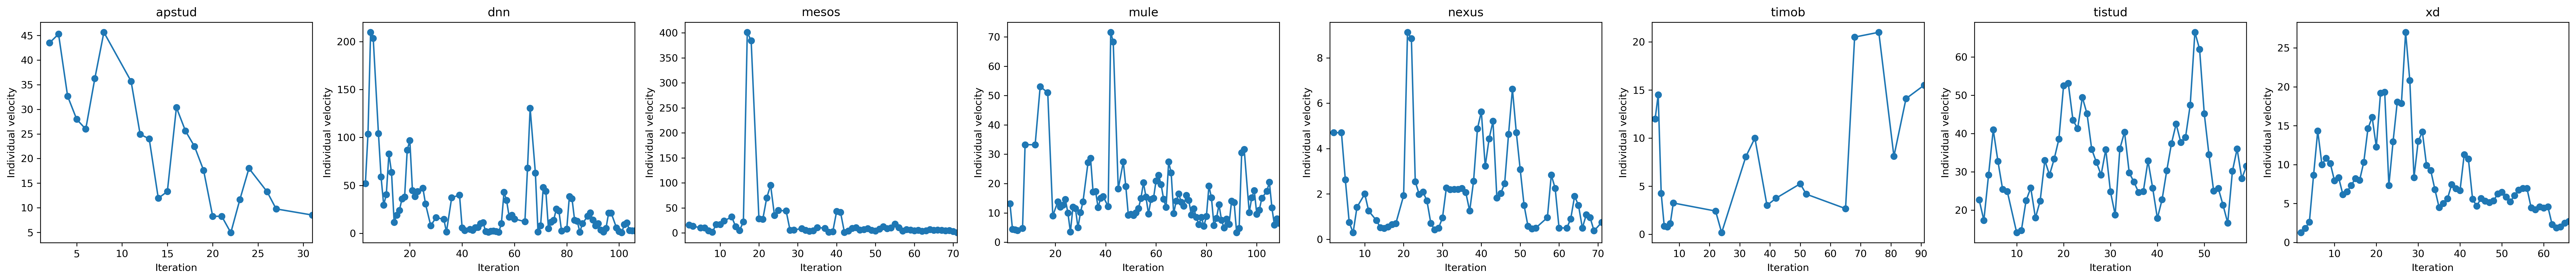

In [55]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(36,4), dpi=300)

dfx = metrics.pivot_table(index='sprint.nbr', columns='project', values='individual_velocity')

#df = df[df['individual_velocity'] < 300]

i=0
for p in dfx.columns:
    i = i + 1
    ax = fig.add_subplot(1, 8, i)
    
    dfx.loc[:, p].dropna().rolling(2).mean().plot(style='-o', label='mean', ax=ax)

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Individual velocity')

    ax.set_title(p)
    
plt.tight_layout()

# Summary

In [56]:
tv = metrics.pivot_table(index='project', values=['sprint.name'], aggfunc='nunique')

table = tv.copy()
table.loc['Total', :] = tv.sum(axis=0)
table.loc['Average', :] = tv.mean(axis=0)
table.loc['Std', :] = tv.std(axis=0)

table.round(2)

,project,sprint.name
project,,
apstud,1.0,33.00
dnn,1.0,107.00
mesos,1.0,71.00
mule,1.0,115.00
nexus,1.0,72.00
timob,1.0,94.00
tistud,1.0,59.00
xd,1.0,66.00
Total,8.0,617.00


In [57]:
# only the issues that belongs to the calculated sprints

# additional field for filtering
full['sprint.key'] = full['project'] + '_' + full['sprint.name']
metrics['sprint.key'] = metrics['project'] + '_' + metrics['sprint.name']

# filter
issues = full[full['sprint.key'].isin(metrics['sprint.key'].unique())]

In [58]:
issues.head(3)

,key,project,sprint.completeDate,sprint.endDate,sprint.id,sprint.name,sprint.startDate,sprint.state,fields.updated,fields.resolutiondate,storypoints,fields.status.name,fields.assignee.name,closed_date,last_status_update_date,velocity_flag,last_update_sprint,sprint.key
0,XD-3744,xd,2016-02-26T16:32:18.620Z,2016-02-26 08:34:00+00:00,108,Sprint 68,2016-02-16 00:38:45.289000+00:00,CLOSED,2016-02-23 17:56:59+00:00,2016-02-22 18:41:31+00:00,1.0,Done,grussell,2016-02-22 18:41:31.399000+00:00,2016-02-22 15:49:30.944000+00:00,True,Sprint 68,xd_Sprint 68
1,XD-3743,xd,2016-02-26T16:32:18.620Z,2016-02-26 08:34:00+00:00,108,Sprint 68,2016-02-16 00:38:45.289000+00:00,CLOSED,2016-02-21 02:28:25+00:00,2016-02-21 02:28:25+00:00,1.0,Done,abilan,2016-02-21 02:28:25.175000+00:00,2016-02-19 18:32:51.250000+00:00,True,Sprint 68,xd_Sprint 68
2,XD-3742,xd,2016-02-26T16:32:18.620Z,2016-02-26 08:34:00+00:00,108,Sprint 68,2016-02-16 00:38:45.289000+00:00,CLOSED,2016-02-23 18:21:39+00:00,2016-02-19 20:04:19+00:00,3.0,Done,dturanski,2016-02-19 20:04:19.342000+00:00,2016-02-17 16:57:54.563000+00:00,True,Sprint 68,xd_Sprint 68


In [59]:
tv = issues.pivot_table(index='project', values=['sprint.name'], aggfunc='nunique')

table = tv.copy()
table.loc['Total', :] = tv.sum(axis=0)
table.loc['Average', :] = tv.mean(axis=0)
table.loc['Std', :] = tv.std(axis=0)

table.round(2)

,project,sprint.name
project,,
apstud,1.0,33.00
dnn,1.0,107.00
mesos,1.0,71.00
mule,1.0,115.00
nexus,1.0,72.00
timob,1.0,94.00
tistud,1.0,59.00
xd,1.0,66.00
Total,8.0,617.00


In [60]:
assert issues['sprint.name'].nunique() == metrics['sprint.name'].nunique()

# Second cleaning step. 

Removing all the null values: iterations with null velocity, work capacity

In [61]:
# there is an outlier in project 
# remove it
metrics_cleaned = metrics[metrics['individual_velocity'] < 300]

# remove all null values (velocity, work capacity, and length)
metrics_cleaned = metrics_cleaned.dropna()

# keep the issues that belongs to the sprints 
issues_cleaned = full[full['sprint.key'].isin(metrics_cleaned['sprint.key'].unique())]

In [62]:
metrics_cleaned.head(3)

,project,sprint.name,issues,velocity,work_capacity,sprint.startDate,sprint.endDate,storypoints,sprint_length,focus_factor,...,new_devs_abs,turnover_abs,current_devs_abs,turnover,new_devs,sprint.nbr,TSI,TSI_inv,individual_velocity,sprint.key
1,apstud,2012 Sprint 03,23,228.0,371.0,2012-01-27 00:00:00+00:00,2012-02-10 00:00:00+00:00,233.0,14.0,0.614555,...,1.0,0.0,4,0.000000,0.071429,2.0,1.333333,0.75,57.00,apstud_2012 Sprint 03
2,apstud,2012 Sprint 04,18,168.0,170.0,2012-02-10 00:00:00+00:00,2012-02-24 00:00:00+00:00,201.0,14.0,0.988235,...,1.0,0.0,5,0.000000,0.055556,3.0,1.333333,0.75,33.60,apstud_2012 Sprint 04
3,apstud,2012 Sprint 05,19,127.0,163.0,2012-02-24 00:00:00+00:00,2012-03-09 00:00:00+00:00,148.0,14.0,0.779141,...,0.0,1.0,4,0.055556,0.000000,4.0,1.333333,0.75,31.75,apstud_2012 Sprint 05


## Re-assing the sprint number

In [63]:
metrics = metrics_cleaned.sort_values(['project', 'sprint.startDate'], ascending=True)

l = []
for p in metrics_cleaned.project.unique():
    size = len(metrics_cleaned[metrics_cleaned.project == p])
    
    metrics_cleaned.loc[metrics_cleaned.project == p, 'sprint.nbr'] = range(1,size+1)

# example
# metrics_cleaned[metrics_cleaned["project"] == "apstud"][['sprint.name', 'sprint.nbr']]

# basic stats (with calculated metrics)

I will remove DNN because its velocity violates the normality assumption

In [64]:
metrics_cleaned = metrics_cleaned[metrics_cleaned['project'] != 'dnn']
issues_cleaned = issues_cleaned[issues_cleaned['project'] != 'dnn']

In [65]:
metrics_cleaned.groupby(['project'])['sprint.name'].nunique()

project
apstud    24
mesos     63
mule      93
nexus     63
timob     22
tistud    57
xd        65
Name: sprint.name, dtype: int64

In [66]:
tv = issues_cleaned.pivot_table(index='project', values=['key', 'sprint.name', 'fields.assignee.name'], aggfunc='nunique')

table = tv.copy()
table.loc['Total', :] = tv.sum(axis=0)
table.loc['Average', :] = tv.mean(axis=0)
table.loc['Std', :] = tv.std(axis=0)

table.columns
table.columns = ['devs', 'issues', 'project', 'iterations']
table = table[['issues', 'iterations', 'devs']].round(2)

In [67]:
h = metrics_cleaned.groupby('project').agg( {'sprint.startDate' : 'min', 
                                         'sprint.endDate' : 'max'} )

h = pd.concat([h, (h['sprint.endDate'] - h['sprint.startDate']).dt.days], axis=1)

In [68]:
tv = pd.concat([tv, h], axis=1)

In [69]:
tv

,fields.assignee.name,key,project,sprint.name,sprint.startDate,sprint.endDate,0
project,,,,,,,
apstud,9,355,1,24,2012-01-27 00:00:00+00:00,2014-01-17 00:00:00+00:00,721
mesos,65,1091,1,63,2014-05-15 21:33:30.978000+00:00,2016-05-11 16:13:00+00:00,726
mule,32,831,1,93,2013-02-20 17:02:24.206000+00:00,2016-05-12 16:51:00+00:00,1176
nexus,16,612,1,63,2013-09-12 20:48:43.459000+00:00,2016-05-10 17:10:00+00:00,970
timob,30,168,1,22,2011-12-03 21:29:08.571428572+00:00,2014-03-14 00:00:00+00:00,831
tistud,15,1728,1,57,2012-01-31 00:00:00+00:00,2014-04-24 00:00:00+00:00,814
xd,31,2102,1,65,2013-05-06 17:52:35.477000+00:00,2016-02-26 08:34:00+00:00,1025


In [70]:
table = tv.copy()
table.loc['Total', :] = tv.sum(axis=0)
table.loc['Median', :] = tv.median(axis=0)
table.loc['Std', :] = tv.std(axis=0)

In [71]:
# unique devs, issues, project, iterations, start date, end date, days

table['sprint.startDate'] = table['sprint.startDate'].dt.strftime('%d.%m.%Y')
table['sprint.endDate'] = table['sprint.endDate'].dt.strftime('%d.%m.%Y')

table.round(2)

,fields.assignee.name,key,project,sprint.name,sprint.startDate,sprint.endDate,0
project,,,,,,,
apstud,9.00,355.00,1.0,24.00,27.01.2012,17.01.2014,721.00
mesos,65.00,1091.00,1.0,63.00,15.05.2014,11.05.2016,726.00
mule,32.00,831.00,1.0,93.00,20.02.2013,12.05.2016,1176.00
nexus,16.00,612.00,1.0,63.00,12.09.2013,10.05.2016,970.00
timob,30.00,168.00,1.0,22.00,03.12.2011,14.03.2014,831.00
tistud,15.00,1728.00,1.0,57.00,31.01.2012,24.04.2014,814.00
xd,31.00,2102.00,1.0,65.00,06.05.2013,26.02.2016,1025.00
Total,198.00,6887.00,7.0,387.00,NaT,NaT,6263.00
Median,30.00,831.00,1.0,63.00,NaT,NaT,831.00


# save

In [72]:
metrics_cleaned.to_csv('processed_data/iteration_metrics_cleaned.csv', index=False)
issues_cleaned.to_csv('processed_data/issues_cleaned.csv', index=False)